# Salinity Group
OOI Data Labs Workshop - March 2019

In [0]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt

## Lesson Background

### Exploration
* **Title:** Changes in Salinity
* **Description:** Explore changes in sea surface salinity over time. (Exploration)
* **Objective:** Use sea surface salinity data from the North Pacific Ocean to identify patterns over time. 
  * Explore salinity data at one location over time.

### Concept Invention
* **Title:** Processes that Change Salinity
* **Description:** Explore oceanic and atmospheric processes that are correlated with changes in salinity over time. (Concept Invention)
* **Objective:** Use water and atmospheric conditions data at and above the ocean surface from the North Pacific Ocean to identify patterns in sea surface salinity.
  * Make predictions and formulate hypotheses about surface salinity changes and the drivers of these changes in one location.
  * Use atmospheric and sea surface data to test predictions about sea surface salinity changes in this location.

### Application
* **Title:** Processes that Change Salinity and Spatial Changes in Salinity    
* **Description:** Explore seawater characteristics of processes that are correlated with changes in salinity over time, and over different locations. (Application)
* **Objective:** Use water and atmospheric conditions data at and above the ocean surface across similar time periods from the North Pacific and North Atlantic Oceans to identify patterns.
  * Make predictions and formulate hypotheses about surface salinity at different locations.  Explain the drivers of these changes. 
  * Use atmospheric and sea surface data to test predictions about sea surface salinity variations between locations.

## Request Data from OOINet

### Exploration
* **Salinity Data:** Coastal Endurance Array Oregon Shelf Surface Mooring, Surface Buoy CE02SHSM-SBD11-06-METBKA000
recovered data from 2015-4-8 to 2018-9-25 (outliers will need to be filtered)
  * The non-salinity variables are: air temperature, sea surface temperature, precipitation

### Concept Invention
* **Salinity Data:** Same as above, but only Q2-15 through Q4-16
  * The non-salinity variables are: air temperature, sea surface temperature, precipitation, and relative wind speed.

### Application
* **Salinity Data:** Separate plot for each data set, stacked vertically in the order indicated below.
  * Coastal Endurance Array Oregon Shelf Surface Mooring, Surface Buoy CE02SHSM-SBD11-06-METBKA000 
    * recovered data from 2015-4-8 to 2018-9-25 (outliers will need to be filtered)  - **Same as Exploration above**
  * Pioneer Inshore Surface Mooring Surface Buoy CP03ISSM-SBD11-06-METBKA000 
    * recovered data from 2015-5-9 to 2018-3-28 
    * telemetered data from 2018-3-28 to present (outliers will need to be filtered)
  * Global Irminger Sea, Apex Surface Mooring, Surface Buoy GI01SUMO-SBD11-06-METBKA000
    * recovered data from 2014-9-10 to 2015-2-16
    * telemetered data from 2015-8-15 to 2019-3-15
* The non-salinity variables are: air temperature, sea surface temperature, precipitation, and relative wind speed.

In [0]:
def request_data(reference_designator,method,stream,start_date,end_date):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
#     'beginDT':start_date,
#     'endDT':end_date,
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# # Endurance Array Oregon Shelf Surface Mooring
# #              '2015-04-08T00:00:00.000Z','2018-09-25T00:00:00.000Z')
# request_data('CE02SHSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered','','')


# # Pioneer Inshore Surface Mooring 
# # recovered data from 2015-5-9 to 2018-3-28
# # telemetered data from 2018-3-28 to present (outliers will need to be filtered)

# request_data('CP03ISSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered','','')

# # Global Irminger Sea, Apex Surface Mooring 
# # recovered data from 2014-9-10 to 2015-2-16
# # telemetered data from 2015-8-15 to 2019-3-15

# request_data('GI01SUMO-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered','','')
# request_data('GI01SUMO-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument','','')

## Load, Average, Merge and Export Datasets

In [0]:
# Resultant Dataset Directories
url_ce = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190329T161019-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_cp = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190329T161059-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_gi = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190329T161114-GI01SUMO-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_gi_tel = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190401T193540-GI01SUMO-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'


In [0]:
def get_data(url,bad_inst=''):
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

### Exploration - Endurance

In [0]:
data_ce = get_data(url_ce,'velpt')

In [0]:
# Remove outliers
data_ce['met_salsurf'] = data_ce['met_salsurf'].where(data_ce['met_salsurf']>0)
data_ce['sea_surface_temperature'] = data_ce['sea_surface_temperature'].where(data_ce['sea_surface_temperature']>0)

In [0]:
# Subset dataset
data_ce2 = data_ce[['met_salsurf','air_temperature','sea_surface_temperature','precipitation','met_relwind_speed']]

In [0]:
# Average
data_ce2 = data_ce2.load().resample(time='1H').mean()

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [0]:
# Calculate Daily Precipitation 
rain = data_ce.precipitation.resample(time='15min').mean().diff('time')
rain = rain.where(rain>0)
rain = rain.resample(time='1D').sum()
data_ce2['rain'] = rain

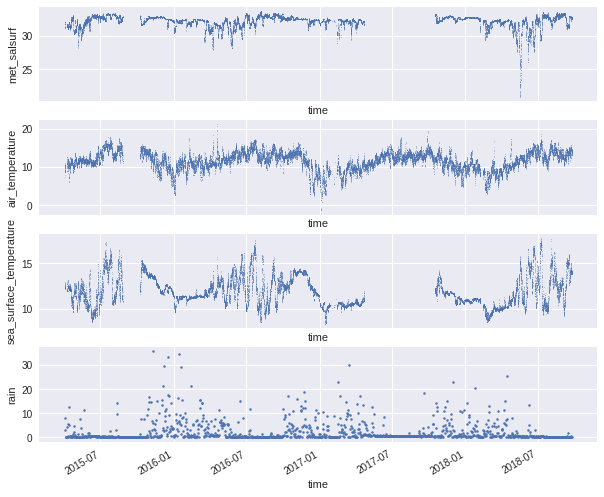

In [0]:
# Plot the data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,8))
data_ce2.met_salsurf.plot(ax=ax1,linestyle='',marker='.',markersize=1)
data_ce2.air_temperature.plot(ax=ax2,linestyle='',marker='.',markersize=1)
data_ce2.sea_surface_temperature.plot(ax=ax3,linestyle='',marker='.',markersize=1)
data_ce2.rain.plot(ax=ax4,linestyle='',marker='.',markersize=5);

In [0]:
# Export to CSV
data_ce2.to_dataframe().to_csv('salinity_exp.csv')

In [0]:
# Other variables?
# data_ce.barometric_pressure.plot() #L0
# data_ce.longwave_irradiance.plot() #L1
# data_ce.relative_humidity.plot() #L1
# data_ce.shortwave_irradiance.plot() #L1
# data_ce.met_barpres.plot() #L1
# data_ce.met_netsirr.plot() #Net Shortwave Irr. L2
# data_ce.met_spechum.plot() # L2 Specific Humidity
# data_ce.ct_depth.plot()

### Concept Invention - Endurance

In [0]:
data_ci = data_ce2.loc[dict(time=slice('2015-04-01', '2016-12-31'))]

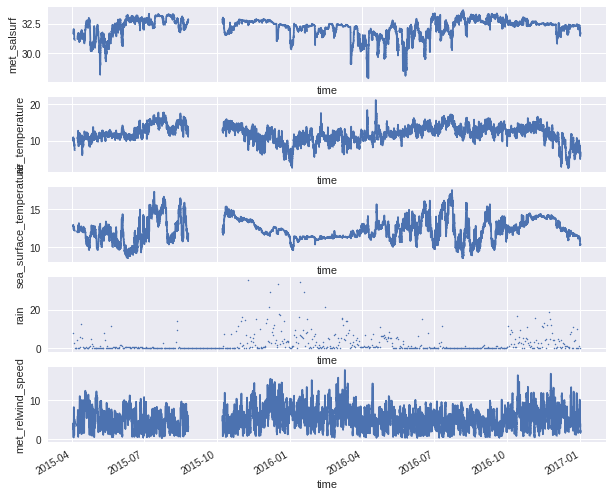

In [0]:
# Plot the data
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, figsize=(10,8))
data_ci.met_salsurf.plot(ax=ax1,linestyle='-',marker='.',markersize=1)
data_ci.air_temperature.plot(ax=ax2,linestyle='-',marker='.',markersize=1)
data_ci.sea_surface_temperature.plot(ax=ax3,linestyle='-',marker='.',markersize=1)
data_ci.rain.plot(ax=ax4,linestyle='-',marker='.',markersize=3);
data_ci.met_relwind_speed.plot(ax=ax5,linestyle='-',marker='.',markersize=1);

In [0]:
# Export to CSV
data_ci.to_dataframe().to_csv('salinity_ci.csv')

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


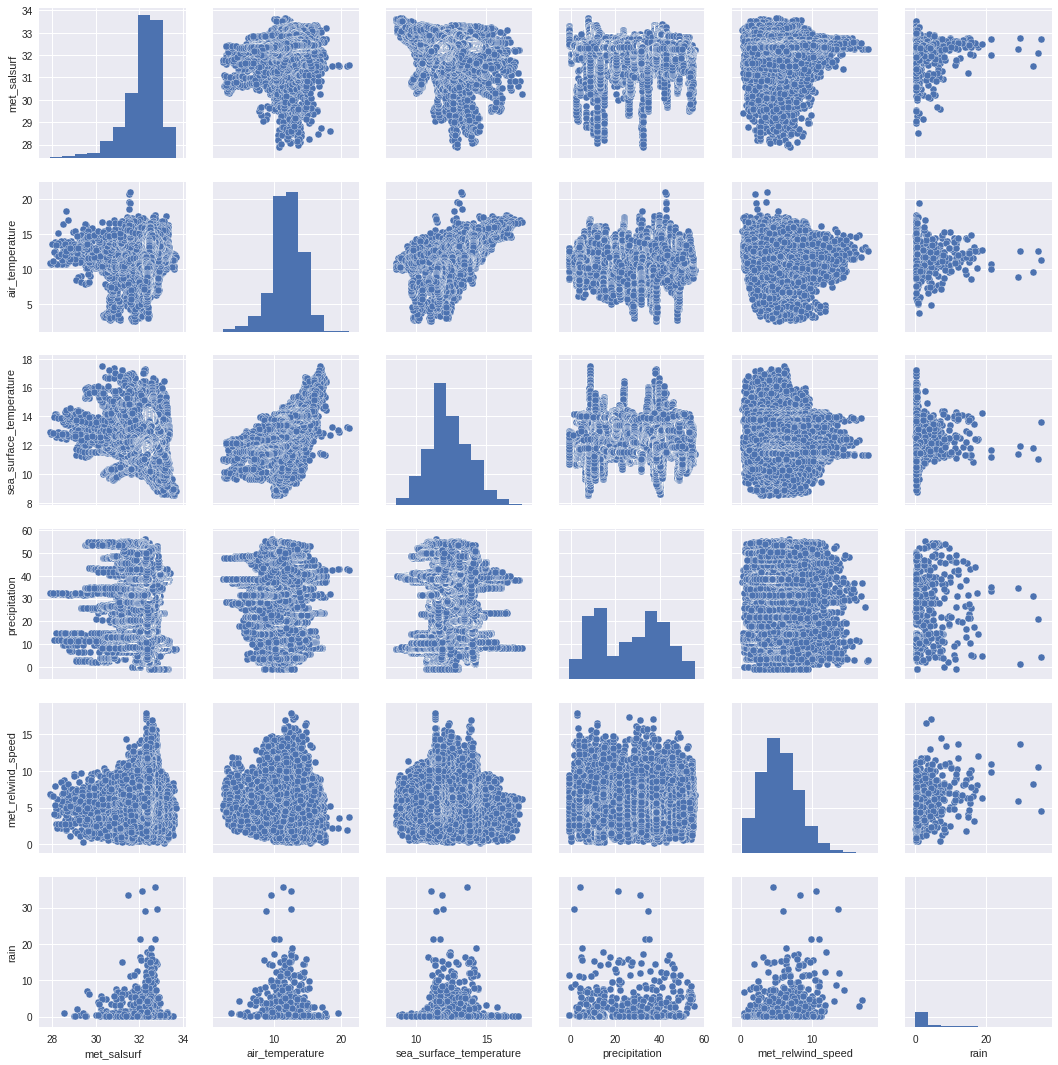

In [0]:
import seaborn as sns
sns.pairplot(data_ci.to_dataframe())

### Application - Pioneer Recovered

In [0]:
data_cp = get_data(url_cp,'velpt')

# Subset dataset
data_cp = data_cp[['met_salsurf','air_temperature','sea_surface_temperature','precipitation','met_relwind_speed']]

# Average
data_cp2 = data_cp.load().resample(time='1H').mean()

# Calculate Daily Precipitation 
rain = data_cp.precipitation.resample(time='15min').mean().diff('time')
rain = rain.where(rain>0)
rain = rain.resample(time='1D').sum()
data_cp2['rain'] = rain

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


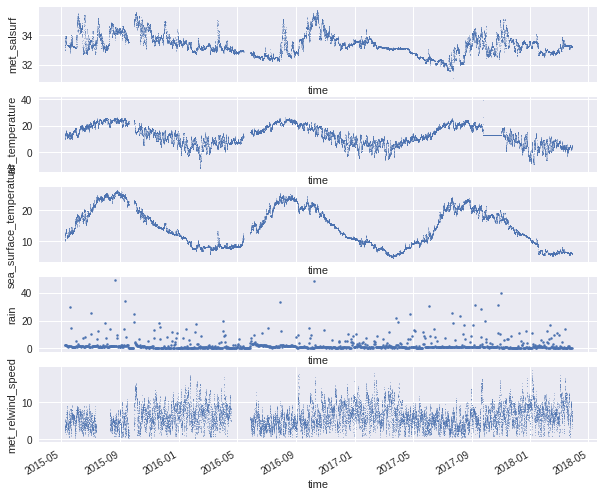

In [0]:
# Plot the data
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, figsize=(10,8))
data_cp2.met_salsurf.plot(ax=ax1,linestyle='',marker='.',markersize=1)
data_cp2.air_temperature.plot(ax=ax2,linestyle='',marker='.',markersize=1)
data_cp2.sea_surface_temperature.plot(ax=ax3,linestyle='',marker='.',markersize=1)
data_cp2.rain.plot(ax=ax4,linestyle='',marker='.',markersize=5);
data_cp2.met_relwind_speed.plot(ax=ax5,linestyle='',marker='.',markersize=1);

### Application - Irminger Recovered

In [0]:
import numpy as np
def reject_outliers(data, m=3):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [0]:
data_gi = get_data(url_gi,'velpt')

# Remove outliers
data_gi['met_salsurf'] = data_gi['met_salsurf'].where(reject_outliers(data_gi['met_salsurf']))

# Subset dataset
data_gi = data_gi[['met_salsurf','air_temperature','sea_surface_temperature','precipitation','met_relwind_speed']]

# Average
data_gi2 = data_gi.load().resample(time='1H').mean()

# Calculate Daily Precipitation 
rain = data_gi.precipitation.resample(time='15min').mean().diff('time')
rain = rain.where(rain>0)
rain = rain.where(reject_outliers(rain))
rain = rain.resample(time='1D').sum()
data_gi2['rain'] = rain

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


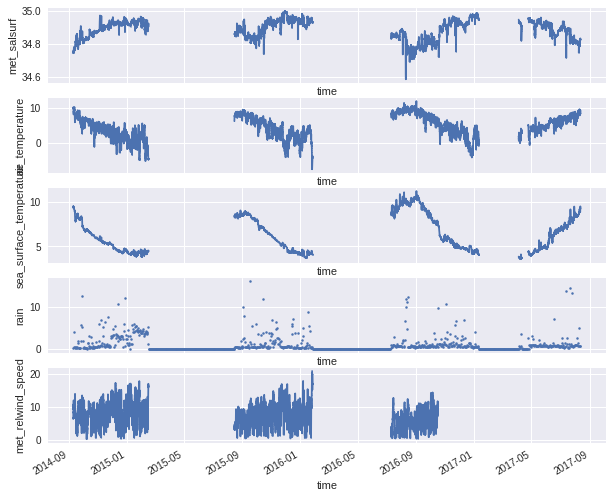

In [0]:
# Plot the data
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, figsize=(10,8))
data_gi2.met_salsurf.plot(ax=ax1,linestyle='-',marker='.',markersize=1)
data_gi2.air_temperature.plot(ax=ax2,linestyle='-',marker='.',markersize=1)
data_gi2.sea_surface_temperature.plot(ax=ax3,linestyle='-',marker='.',markersize=1)
data_gi2.rain.plot(ax=ax4,linestyle='',marker='.',markersize=5);
data_gi2.met_relwind_speed.plot(ax=ax5,linestyle='-',marker='.',markersize=1);

### Application - Irminger Telemetered

In [0]:
data_git = get_data(url_gi_tel,'velpt')

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


In [0]:
# Remove outliers
# data_git['met_salsurf'] = data_git['met_salsurf'].where(data_git['met_salsurf']>0)
data_git = data_git.where(data_git['met_salsurf']>20)

# Subset dataset
data_git = data_git[['met_salsurf','air_temperature','sea_surface_temperature','precipitation','met_relwind_speed']]

# # Average
data_git2 = data_git.load().resample(time='1H').mean()

# Calculate Daily Precipitation 
rain = data_git.precipitation.resample(time='15min').mean().diff('time')
rain = rain.where(rain>0)
rain = rain.where(reject_outliers(rain))
rain = rain.resample(time='1D').sum()
data_git2['rain'] = rain

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


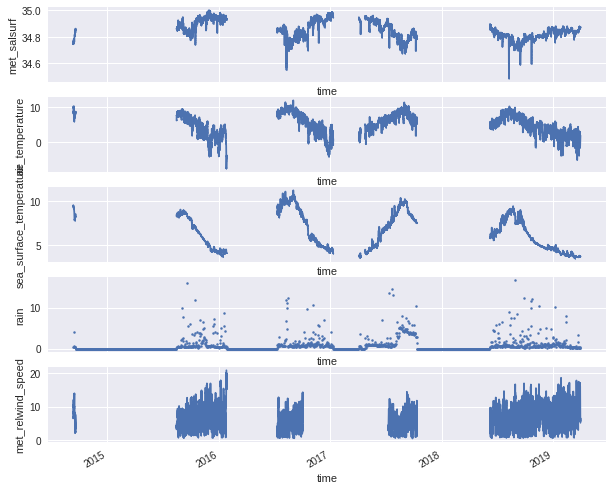

In [0]:
# Plot the data
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, figsize=(10,8))
data_git2.met_salsurf.plot(ax=ax1,linestyle='-',marker='.',markersize=1)
data_git2.air_temperature.plot(ax=ax2,linestyle='-',marker='.',markersize=1)
data_git2.sea_surface_temperature.plot(ax=ax3,linestyle='-',marker='.',markersize=1)
data_git2.rain.plot(ax=ax4,linestyle='',marker='.',markersize=5);
data_git2.met_relwind_speed.plot(ax=ax5,linestyle='-',marker='.',markersize=1);

### Application Merge Datasets

In [0]:
# Merge the datasets
a = data_ce2.rename({'met_salsurf':'ce_sal', 
                     'air_temperature':'ce_airtemp', 
                     'sea_surface_temperature':'ce_sst',
                     'rain':'ce_rain',
                     'met_relwind_speed':'ce_windspd'})

b = data_cp2.rename({'met_salsurf':'cp_sal', 
                     'air_temperature':'cp_airtemp', 
                     'sea_surface_temperature':'cp_sst',
                     'rain':'cp_rain',
                     'met_relwind_speed':'cp_windspd'})

c = data_gi2.rename({'met_salsurf':'gi_sal', 
                     'air_temperature':'gi_airtemp', 
                     'sea_surface_temperature':'gi_sst',
                     'rain':'gi_rain',
                     'met_relwind_speed':'gi_windspd'})
a = a.drop(['precipitation'])
b = b.drop(['precipitation'])
c = c.drop(['precipitation'])

x = xr.merge([a,b,c]).to_dataframe()
# x.head()

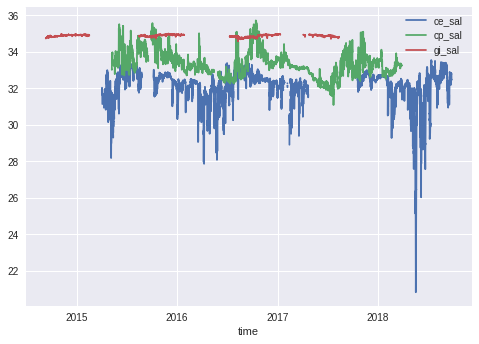

In [0]:
x[['ce_sal','cp_sal','gi_sal']].plot();

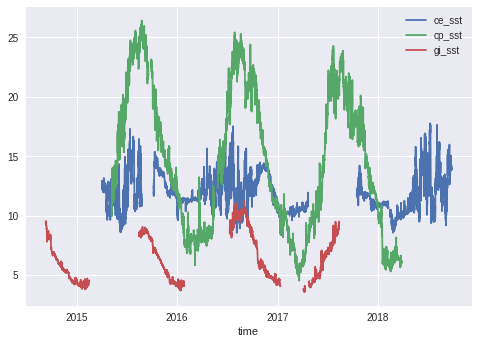

In [0]:
x[['ce_sst','cp_sst','gi_sst']].plot();

In [0]:
# Export to CSV
x.to_csv('salinity_app.csv')